## Advanced Lane Finding

The Project
---

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
# imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle

%matplotlib inline

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### Calibration using chessboad images

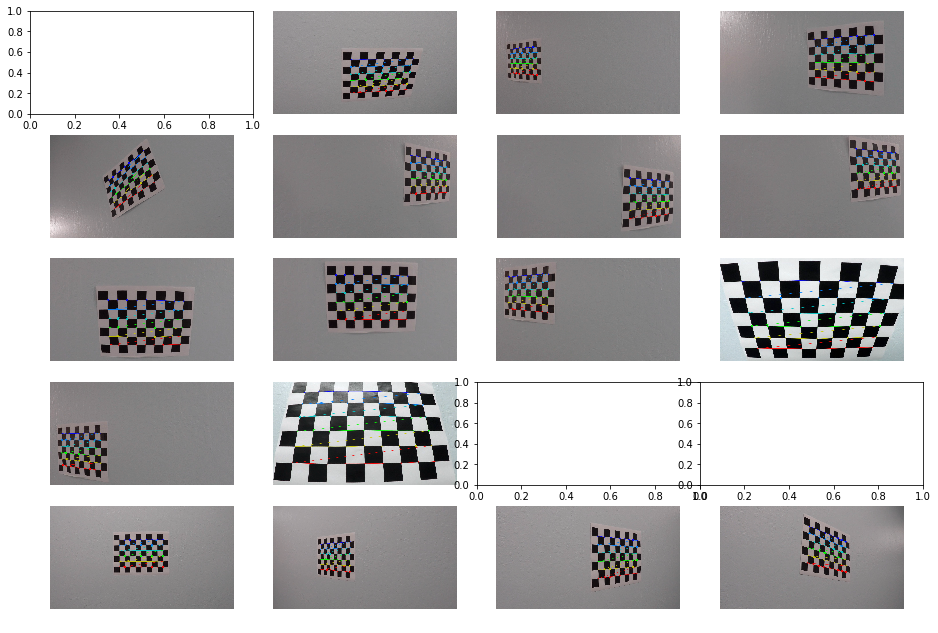

In [2]:
# prepare object points
nx = 9
ny = 6

objpoints = [] # 3D points on distorted images
imgpoints = [] # 2D points on undistorted image

objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)


# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

fig, axs = plt.subplots(5,4, figsize=(16, 11))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i, fname in enumerate(images):
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    # If found, add object points and image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        axs[i].axis('off')
        axs[i].imshow(img)



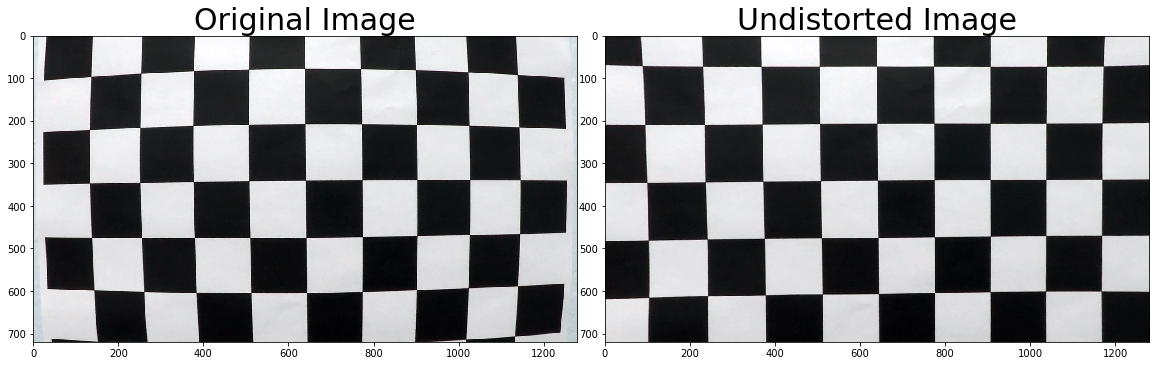

In [3]:
# Calibrate the camera using the corners found.
_, mtx, dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Test the calibration on one of the distorted chessboard images
test_img = cv2.imread('camera_cal/calibration1.jpg')
undistorted = cv2.undistort(test_img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=30)

# Save the calibartion to use later without re-calibration
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration_pickle.p", "wb" ) )

### Undistort test image

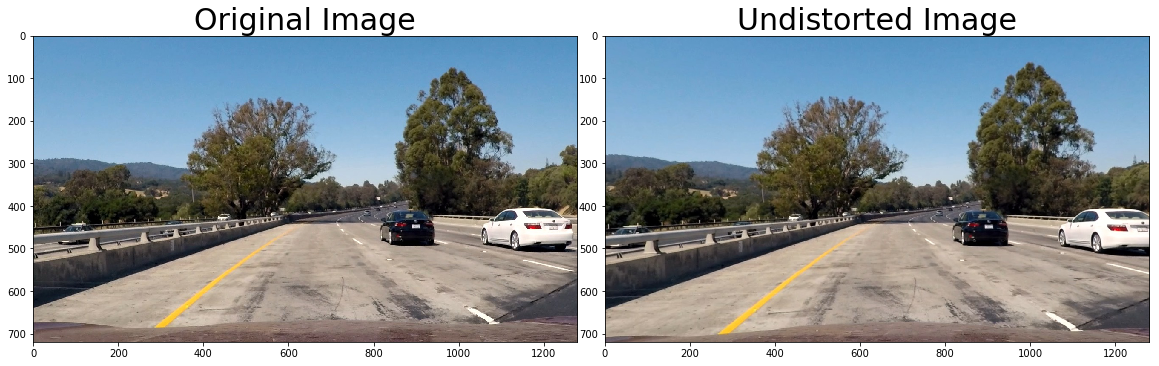

In [4]:
test_img = cv2.imread('./test_images/test1.jpg')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
undistorted = cv2.undistort(test_img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=30)
f.subplots_adjust(hspace = .2, wspace=.05)


The effect of undistortion is evendent at the hood of the car.

### Perpective Transform (unwarp)
The following function applies a transform to change to birds-eye view

In [5]:
# src and dst points for transform
# arrived at these points by examining the staright lines test images.
src = np.float32([[247, 680], [1060, 680], [689, 450], [590, 450]])
dst = np.float32([[350, 719], [929, 719], [929, 0], [350, 0]])

# the transform matrix
M = cv2.getPerspectiveTransform(src, dst)
# the inverse transform matrix
Minv = cv2.getPerspectiveTransform(dst, src) 

def unwarp(img, M):
    # warp image to a top-down view
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

# function to perform the undistort as well as unwarp
def rectify(img, mtx, dist, M):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    warped = unwarp(undist, M)
    return warped

#### Test the rectify function on a test image

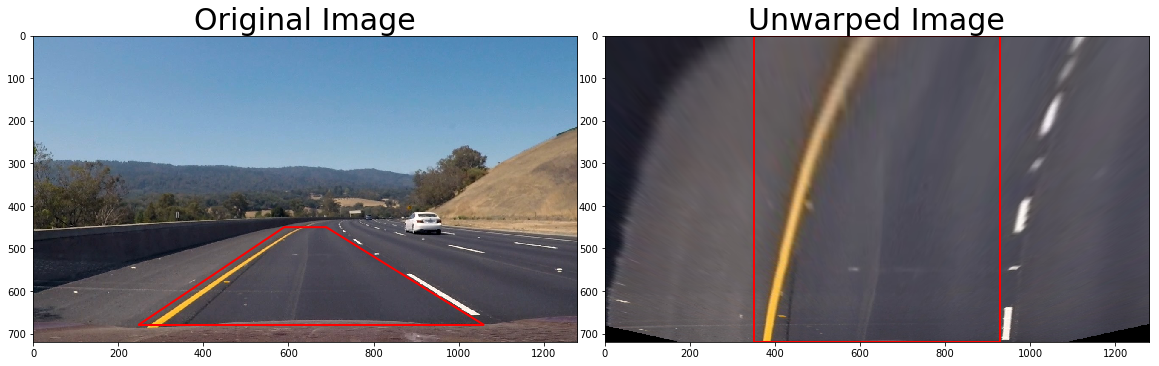

In [6]:
from matplotlib.path import Path
import matplotlib.patches as patches

# Test rectify on sample image
test_img = cv2.imread('./test_images/test3.jpg')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

rectified = rectify(test_img, mtx, dist, M)

codes = [Path.MOVETO,
         Path.LINETO,
         Path.LINETO,
         Path.LINETO,
         Path.CLOSEPOLY
         ]


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_img)
src_vert = np.copy(src)
src_vert = np.append(src_vert, [src_vert[0]], axis=0)
src_path = Path(src_vert, codes)
patch = patches.PathPatch(src_path, fc='none', ec='red', lw=2)
ax1.add_patch(patch)
ax1.set_title('Original Image', fontsize=30)

ax2.imshow(rectified)
dst_vert = np.copy(dst)
dst_vert = np.append(dst_vert, [dst_vert[0]], axis=0)
dst_path = Path(dst_vert, codes)
patch = patches.PathPatch(dst_path, fc='none', ec='red', lw=2)
ax2.add_patch(patch)
ax2.set_title('Unwarped Image', fontsize=30)
f.subplots_adjust(hspace = .2, wspace=.05)

### Color transforms and gradients, to create a thresholded binary image.
Here the pipeline converts takes the HSV space and splits the S and V channels. It also utilizes the grayscale image and produces a combined binary image.

It also produces a color image with shows the VSG channels as RGB

In [7]:
def pipeline(img, mtx, dist, M, s_thresh=(230, 250), v_thresh=(225, 255), sx_thresh=(25, 255)):
    img = np.copy(img)
    img = rectify(img, mtx, dist, M)
    # Convert to HSV color space and separate the SV channels
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    s_channel = hsv[:,:,1]
    v_channel = hsv[:,:,2]

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold S channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Threshold V channel
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= v_thresh[0]) & (v_channel <= v_thresh[1])] = 1
    
    # Stack each channel
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(v_binary == 1) | (s_binary == 1) | (sxbinary == 1)] = 1
    color_binary = np.dstack((v_binary, sxbinary, s_binary)) * 255
    return color_binary, combined_binary

#### Test Pipeline on all test images

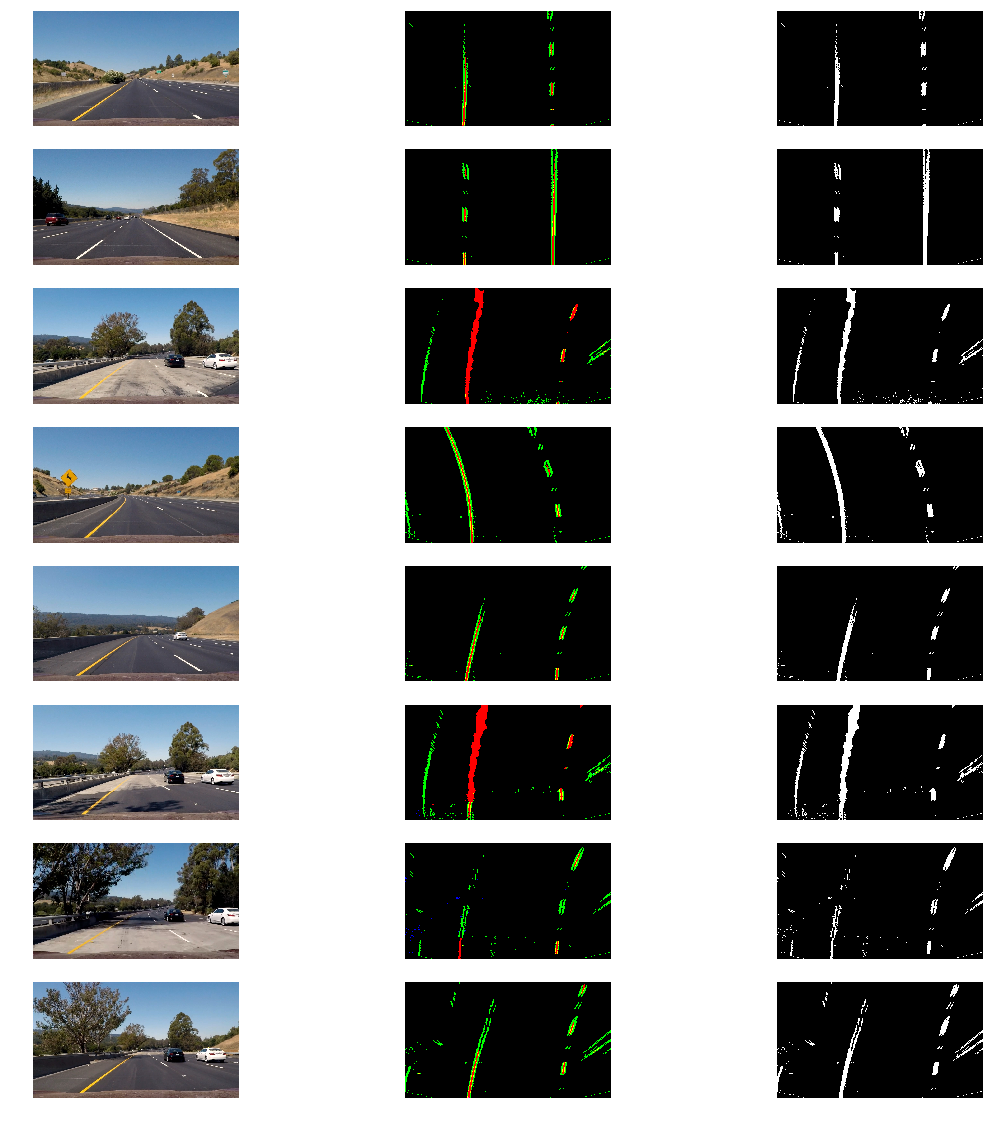

In [8]:
images = glob.glob('./test_images/*.jpg')

fig, axs = plt.subplots(len(images),3, figsize=(20, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i, fname in enumerate(images):
    ax_i = i*3
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    color_binary, combined_binary = pipeline(img, mtx, dist, M, s_thresh=(230, 250), v_thresh=(225, 255), sx_thresh=(25, 255))
    axs[ax_i].imshow(img)
    axs[ax_i].axis('off')
    
    axs[ax_i+1].imshow(color_binary)
    axs[ax_i+1].axis('off')
    
    axs[ax_i+2].imshow(combined_binary, cmap='gray')
    axs[ax_i+2].axis('off')

### Sliding Window to fit ploynomial

In [9]:
def sliding_window(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # to hold the window co-ordinates
    windows = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        windows.append((win_xleft_low,win_xleft_high,win_xright_low,win_xright_high,win_y_low,win_y_high))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, windows

#### Visualize Sliding window poly-fit

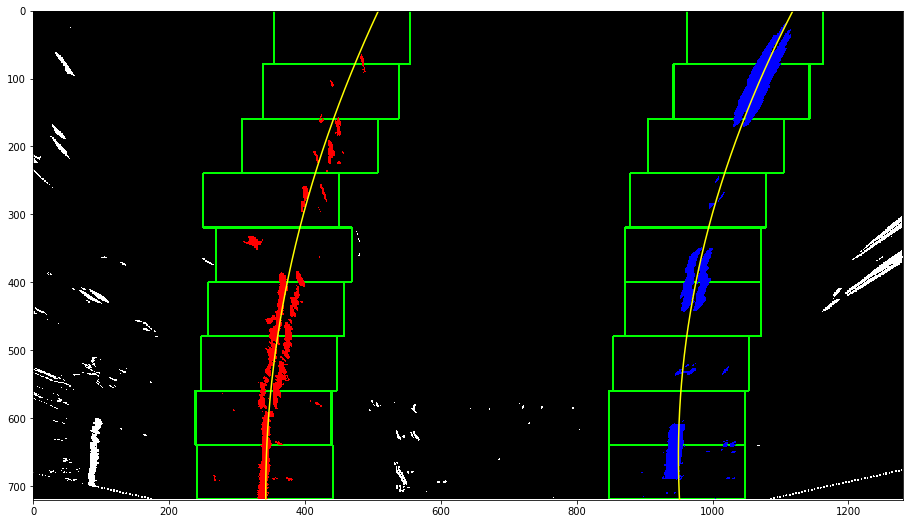

In [10]:
test_img = cv2.imread('./test_images/test5.jpg')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

_, binary_warped = pipeline(test_img, mtx, dist, M, s_thresh=(230, 250), v_thresh=(225, 255), sx_thresh=(25, 255))

left_fit, right_fit, left_lane_inds, right_lane_inds, windows = sliding_window(binary_warped)

out_img =np.dstack((binary_warped, binary_warped, binary_warped))*255

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

for window in windows:
    cv2.rectangle(out_img,(window[0],window[4]),(window[1],window[5]),(0,255,0), 2) 
    cv2.rectangle(out_img,(window[2],window[4]),(window[3],window[5]),(0,255,0), 2) 
    
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

plt.figure(figsize=(16,9))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

### Skip sliding window if lines are known

In [11]:
def fit_prev(binary_warped, left_fit_p, right_fit_p):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit_p[0]*(nonzeroy**2) + left_fit_p[1]*nonzeroy + 
    left_fit_p[2] - margin)) & (nonzerox < (left_fit_p[0]*(nonzeroy**2) + 
    left_fit_p[1]*nonzeroy + left_fit_p[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit_p[0]*(nonzeroy**2) + right_fit_p[1]*nonzeroy + 
    right_fit_p[2] - margin)) & (nonzerox < (right_fit_p[0]*(nonzeroy**2) + 
    right_fit_p[1]*nonzeroy + right_fit_p[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds

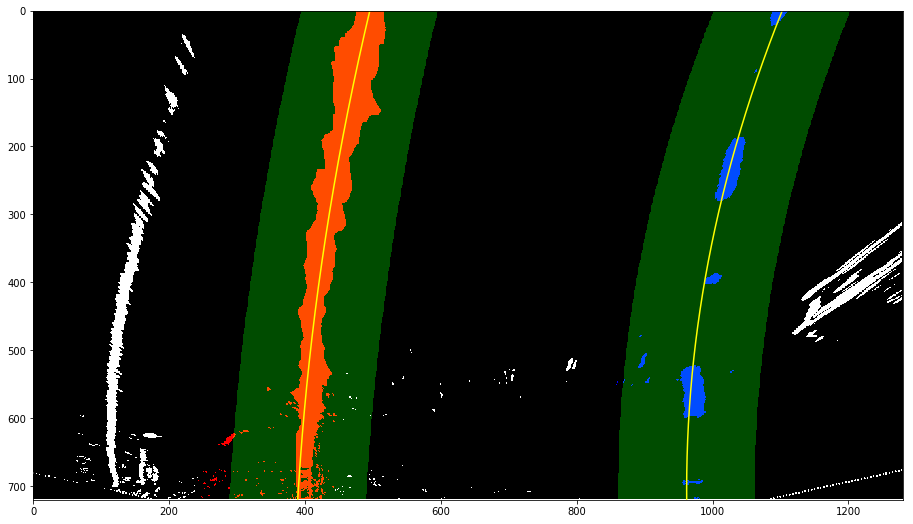

In [12]:
test_img2 = cv2.imread('./test_images/test4.jpg')
test_img2 = cv2.cvtColor(test_img2, cv2.COLOR_BGR2RGB)
margin = 100

_, binary_warped = pipeline(test_img2, mtx, dist, M, s_thresh=(230, 250), v_thresh=(225, 255), sx_thresh=(25, 255))

left_fit_n, right_fit_n, left_lane_inds_n, right_lane_inds_n = fit_prev(binary_warped, left_fit, right_fit)

out_img =np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)

nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds_n], nonzerox[left_lane_inds_n]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds_n], nonzerox[right_lane_inds_n]] = [0, 0, 255]

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit_n[0]*ploty**2 + left_fit_n[1]*ploty + left_fit_n[2]
right_fitx = right_fit_n[0]*ploty**2 + right_fit_n[1]*ploty + right_fit_n[2]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

plt.figure(figsize=(16,9))
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

### Determine the curvature of the lane and vehicle position with respect to center

In [13]:
def calculate_curvature_and_distance(img, left_fit, right_fit, left_lane_inds, right_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    h = img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
    
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Car distance from center
    car_pos = img.shape[1]/2
    xr_ymax = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
    xl_ymax = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
    
    lane_center = (xr_ymax + xl_ymax)/2
    
    car_dist = (lane_center - car_pos) * xm_per_pix
    
    return left_curverad, right_curverad, car_dist

In [14]:
left_curverad, right_curverad, car_dist = calculate_curvature_and_distance(binary_warped, left_fit_n, right_fit_n,
                                                                           left_lane_inds_n, right_lane_inds_n)

print('Radius Left:', left_curverad, 'm')
print('Radius Right:', right_curverad, 'm')
print('Car distance from center:', car_dist, 'm')

Radius Left: 1328.685160449983 m
Radius Right: 578.6784692563067 m
Car distance from center: 0.18868297192521755 m


### Warp the detected lane boundaries back onto the original image

In [15]:
def draw_lane(img, left_fit, right_fit, Minv):
    img = np.copy(img)
    # Create an image to draw the lines on
    color_warp = np.zeros_like(img)
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result

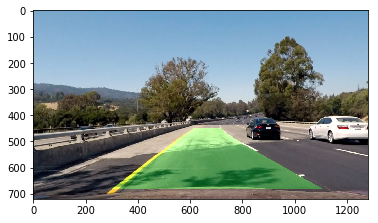

In [16]:
img = cv2.imread('./test_images/test4.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.undistort(img, mtx, dist, None, mtx)
lane_img = draw_lane(img, left_fit_n, right_fit_n, Minv)
plt.imshow(lane_img)
plt.show()